In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim


import cv2

# Logger

In [2]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('SqueezeNet Classifier. First Test.')

# Config

In [3]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [4]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        self.images_path, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1

                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = (img / 255.0)
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        return img, {'smoke': label[0], 'fire': label[1]}

### View Dataset

In [5]:
ds_dir = '../../ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['.ipynb_checkpoints', 'labels', 'images']


### Transform

In [6]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [7]:
dfire_ds = DFireDataset(img_h=IMG_H, 
                        img_w=IMG_W, 
                        img_dir=val_imgs, 
                        label_dir=val_labels, 
                        num_classes=N_CLASSES,
                        transform=view_transform)

VIEW_BATCH_SIZE = 32
view_loader = DataLoader(dataset=dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(len(dfire_ds))

DFire Removed wrong images: 0
4306


# Plot Dataset Pictures

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


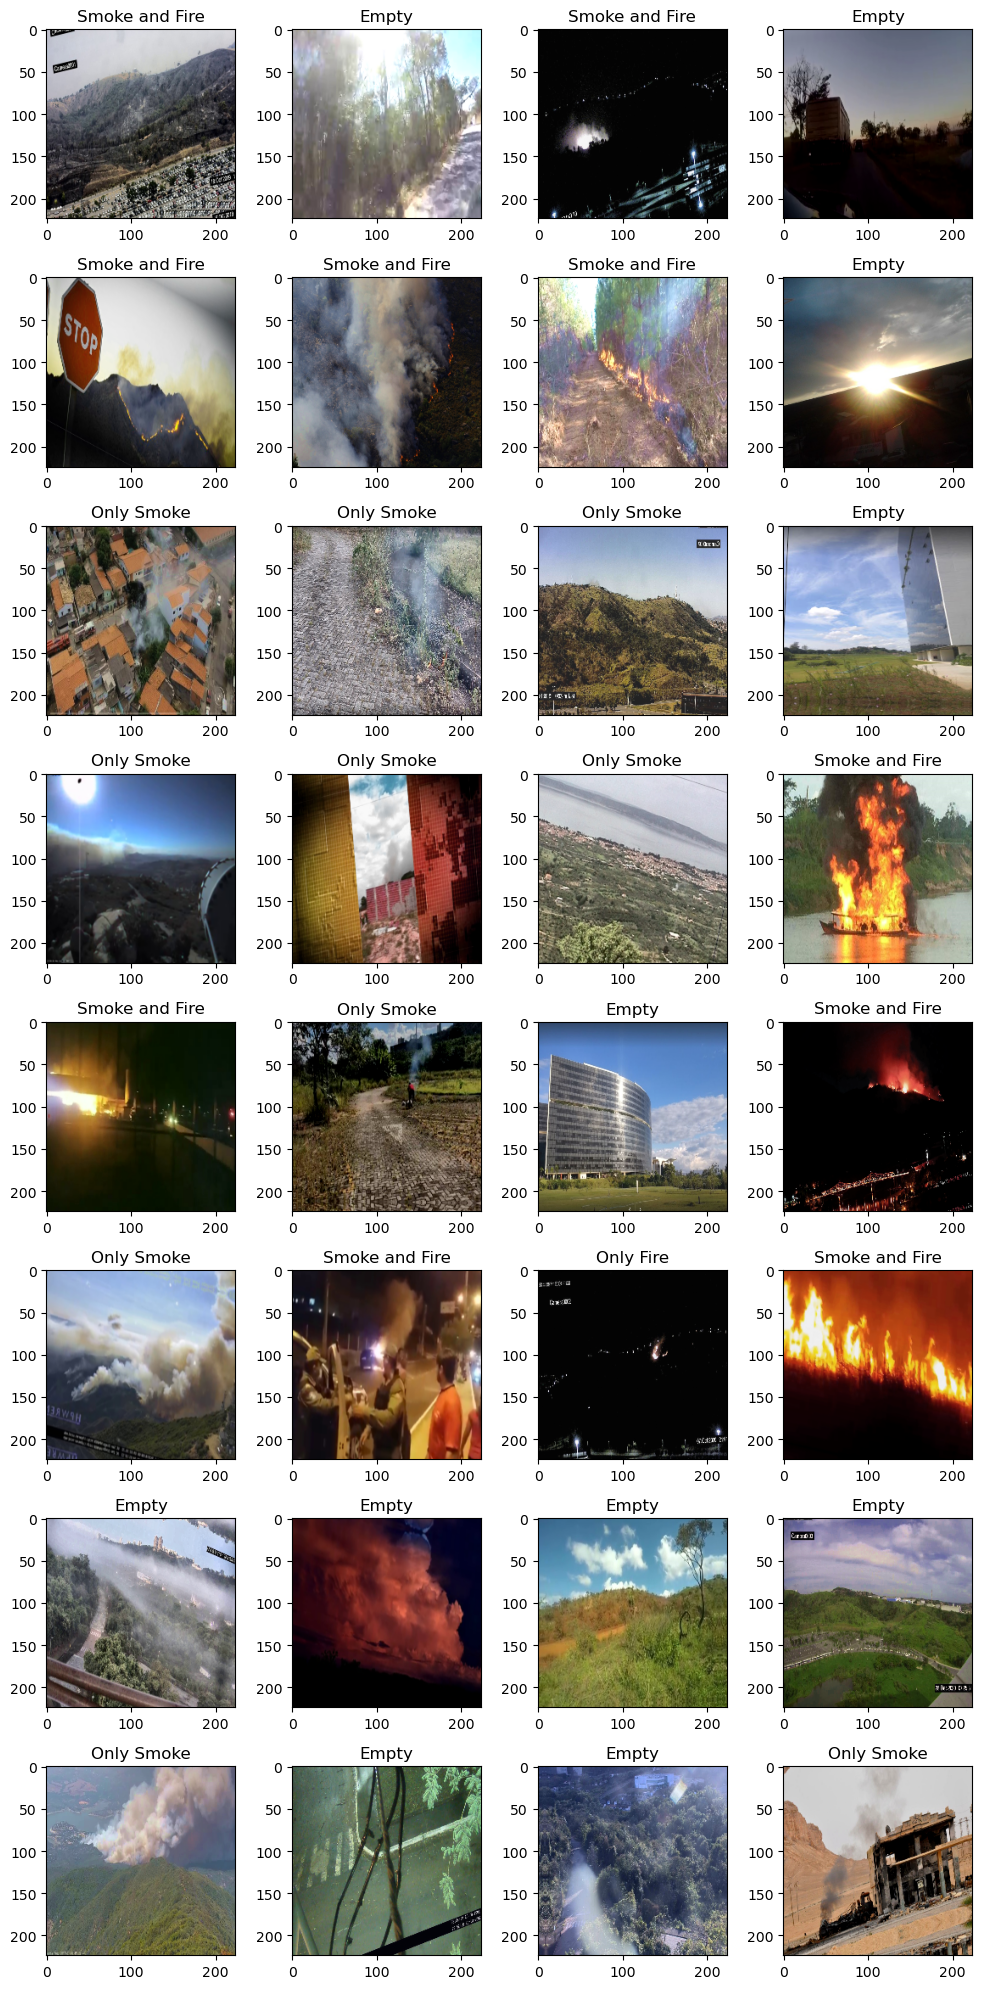

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label['smoke'][idx] == 1 and label['fire'][idx] == 1:
            title += "Smoke and Fire"
        elif label['smoke'][idx] == 1 and label['fire'][idx] == 0:
            title += "Only Smoke"
        elif label['smoke'][idx] == 0 and label['fire'][idx] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# MODEL: OPTIM BED

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 128
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        # x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        # x = torch.sigmoid(x)
        return {
            'smoke': torch.sigmoid(self.smoke(x)),
            'fire': torch.sigmoid(self.fire(x))
        }

# Check Model Shape

In [25]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)

in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Classifier Arquitecture\n{model}')

Model shape is {'smoke': tensor([[0.5042],
        [0.5369],
        [0.5320],
        [0.5916]], device='cuda:0', grad_fn=<SigmoidBackward0>), 'fire': tensor([[0.4524],
        [0.4023],
        [0.4242],
        [0.4449]], device='cuda:0', grad_fn=<SigmoidBackward0>)}
BED Classifier Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, ke

# Loss

In [ ]:
def get_loss(self, label, pred):
    loss_fn = nn.BCELoss()
    smoke_loss = loss_fn(label['smoke'], pred['smoke'])
    fire_loss = loss_fn(label['fire'], pred['fire'])
    loss = smoke_loss + fire_loss
    return loss, {'smoke': smoke_loss, 'fire': fire_loss}


# Train Loop

In [ ]:
'''
Train function
'''
# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# def train_fn(loader, model, optimizer, loss_fn, loss_l1_lambda, device):
    
#     print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
#     logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

#     model.train()
#     loop = tqdm(loader, desc='Training', leave=True)
#     train_mean_loss = []
#     mean_box_loss = []
#     mean_confidence_loss = []
#     mean_noobj_loss = []
#     mean_class_loss = []

#     for batch_idx, (x, y) in enumerate(loop):
# #     for batch_idx, (x, y) in enumerate(loader):
#         x, y = x.to(device), y.to(device)
#         out = model(x)
#         train_loss = loss_fn(ground_truth=y, 
#                              predictions=out)
# #         loss = loss_fn.forward(ground_truth=y, 
# #                        predictions=out)

#         l1_lambda = loss_l1_lambda  # hyperparameter for L1 regularization
#         l1_norm = sum(p.abs().sum() for p in model.parameters())
#         train_loss = train_loss + l1_lambda * l1_norm
        
#         # Gradient Descent
#         optimizer.zero_grad()
#         train_loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
#         optimizer.step()

#         # update progress bar
#         #loop.set_postfix(loss=loss.item())
#         #print(f'Partial Train Loss: {loss.item()}')

#         # MSE Loss
#         xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
#         # Appending each loss
#         train_mean_loss.append(train_loss.item())
#         box_loss = xy_loss + wh_loss
#         mean_box_loss.append(box_loss)
#         mean_confidence_loss.append(obj_loss)
#         mean_noobj_loss.append(noobj_loss)
#         mean_class_loss.append(class_loss)


#     train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
#     #print("\nTRAIN losses")
#     logger.info("\nTRAIN losses")
#     mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
#     mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
#     mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
#     mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  

#     print("Total Loss".ljust(12) + "|" + 
#           "Box Loss".ljust(12) + "|" + 
#           "Conf Loss".ljust(12) + "|" + 
#           "No Obj Loss".ljust(12) + "|" + 
#           "Class Loss".ljust(12))
#     print("------------".ljust(12) + " " + 
#           "------------".ljust(12) + " " + 
#           "------------".ljust(12) + " " + 
#           "------------".ljust(12) + " " + 
#           "------------".ljust(12))
#     print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
#           f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
#           f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
#           f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
#           f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")
    
#     logger.info("Total Loss".ljust(12) + "|" + 
#                   "Box Loss".ljust(12) + "|" + 
#                   "Conf Loss".ljust(12) + "|" + 
#                   "No Obj Loss".ljust(12) + "|" + 
#                   "Class Loss".ljust(12))
#     logger.info("------------".ljust(12) + " " + 
#                   "------------".ljust(12) + " " + 
#                   "------------".ljust(12) + " " + 
#                   "------------".ljust(12) + " " + 
#                   "------------".ljust(12))
#     logger.info(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
#                   f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
#                   f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
#                   f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
#                   f'{mean_class_loss_out:.3f}'.ljust(12))
    
#     return (train_mean_loss_out, 
#             mean_box_loss_out, 
#             mean_confidence_loss_out, 
#             mean_noobj_loss_out, 
#             mean_class_loss_out)
    
# #     return train_mean_loss_out